In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'  
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 1.13.1+cu117
Torchvision version: 0.14.1+cu117
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /scratch/7053720.1.academic-gpu/pip-req-build-8xeqokej
  Running command git clone --quiet https://github.com/facebookresearch/segment-anything.git /scratch/7053720.1.academic-gpu/pip-req-build-8xeqokej
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 8991c14de4b7479f027a2393cf23b6cc5d25f882
  Preparing metadata (setup.py) ... done
--2023-04-07 19:01:52--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.77.63, 13.35.77.52, 13.35.77.35, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.77.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: 'sam_vit_h_4b8939.pth.1'

100%[====================================>] 2,564,550,87

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os
import tqdm

In [24]:
path = ""
img_path = os.path.join(path,'inputs')
sam_path = os.path.join(path,'sam_outputs')
json_path = os.path.join(sam_path,'npy')
mask_path = os.path.join(sam_path,'mask')

In [25]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

def create_mask(anns):
  m = anns[0]['segmentation']
  out = np.ones((m.shape[0], m.shape[1]))
  sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
  for ann in sorted_anns:
    m = ann['segmentation']
    out = out+ m
  return out


In [26]:
img_list = os.listdir(img_path)

In [27]:
image = cv2.imread(os.path.join(img_path,img_list[0]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

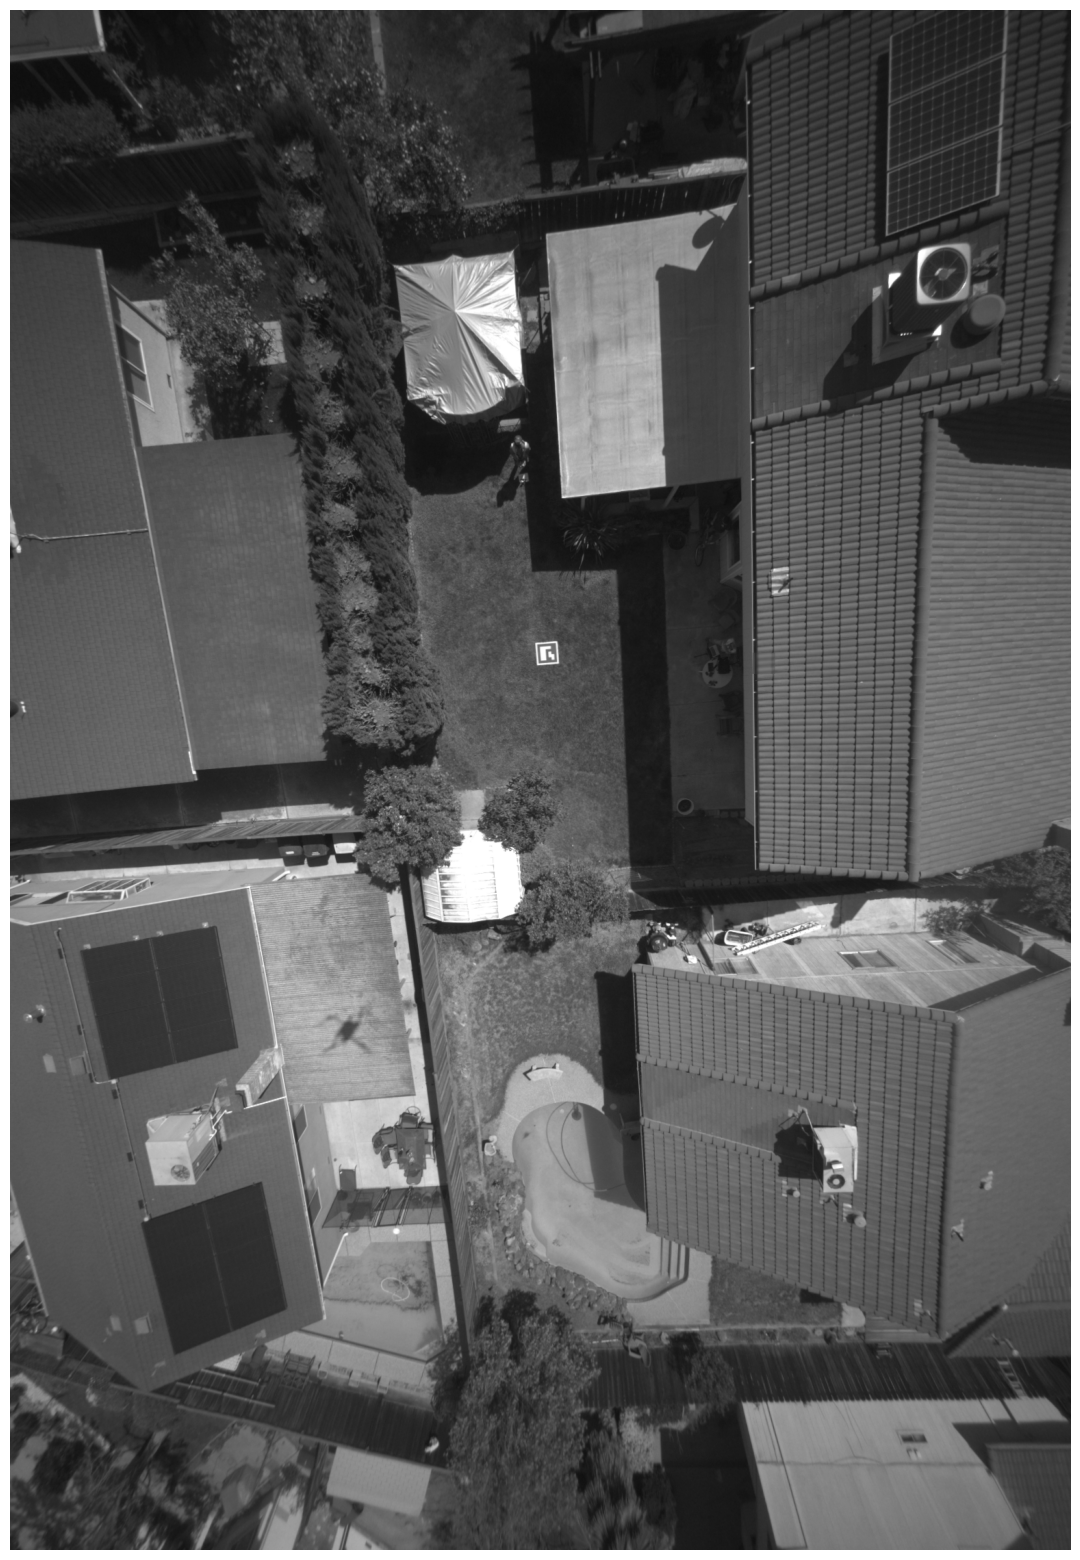

In [28]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [29]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [30]:
masks = mask_generator.generate(image)

In [31]:
print(len(masks))
print(masks[0].keys())

158
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [38]:
#create mask for all images
for img_n in tqdm.tqdm_notebook(img_list):
    if os.path.isfile(os.path.join(mask_path,img_n))==False:
    

        image = cv2.imread(os.path.join(img_path,img_n))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        masks = mask_generator.generate(image)
        #np.save(os.path.join(json_path,img_n[:-3]+'npy'),  masks)    
        out = create_mask(masks)
        cv2.imwrite(os.path.join(mask_path,img_n),out)

/usr4/ec500/vadithya/.conda/envs/carla/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1786 [00:00<?, ?it/s]